## 📄 Preserving Table Structure for Better Retrieval

Financial documents like 10-Qs and earnings releases often contain important data inside tables. These tables are usually embedded in PDFs, which makes them hard to extract and even harder to query later.

In this notebook, we'll build a pipeline to process those documents and preserve the tabular structure in a way that's usable by downstream applications.

Specifically, we'll:

- Use **Unstructured** to extract tables from PDFs and represent them as HTML
- Store the structured HTML chunks in **AstraDB** with OpenAI embeddings
- Run semantic queries to fetch tables related to a question
- Display the tables as HTML to preserve layout and formatting

The goal here is not generation or summarization, it's to keep the table structure intact so it can be used by other systems, agents, or UI components later on.

This approach is useful when working with data where much of the critical information is stored in tables, and structure needs to be preserved for any downstream use.


#Preparing the Data
To prepare data for retrieval, we need to first break down the raw PDFs into structured chunks. This step is foundational for any RAG pipeline, and it’s where [Unstructured](https://unstructured.io) comes in.

The Unstructured API lets us:
- Extract clean, structured content from any document.
- Generates metadata, chunk text, and prep it for downstream applications.

## Setting Up the Unstructured Client

Before we can begin parsing documents, we need to set up access to [Unstructured](https://unstructured.io). The Unstructured API allows us to programmatically process documents, extract structured elements, and prepare them for chunking and embedding, all from within this notebook.

[Contact us](https://unstructured.io/enterprise) to get access or log in if you're already a user.


In [ ]:
!pip install -U "unstructured-client"

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.2/207.2 kB 8.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 313.2/313.2 kB 16.3 MB/s eta 0:00:00


If you haven’t already:
1. Login
2. In the sidebar, go to **API Keys**.
3. Click **New Key**, give it a name, and copy the key.


In [ ]:
import os
import time
from google.colab import userdata
from unstructured_client import UnstructuredClient

Fetching the keys from Colab Secrets!

In [ ]:
os.environ['UNSTRUCTURED_API_KEY'] = userdata.get("UNSTRUCTURED_API_KEY")
client = UnstructuredClient(api_key_auth=os.getenv("UNSTRUCTURED_API_KEY"))

In [ ]:
# utility for inspecting responses in a readable way
def pretty_print_model(response_model):
    print(response_model.model_dump_json(indent=4))

## Setting up the S3 Source Connector


We’ll start by connecting to our document source on S3.

This example uses **AWS access key and secret** for authentication. You'll want to save the following secrets in Colab beforehand:

- `AWS_ACCESS`
- `AWS_SECRET`
- `S3_REMOTE_URL` — the URI to your S3 bucket, e.g.:
  - `s3://my-bucket/` (for root-level files)
  - `s3://my-bucket/my-folder/` (for nested folders)

Once those are set, we can spin up a source connector that points to your remote content.

Need more auth options? [Check the docs](https://docs.unstructured.io/api-reference/workflow/sources/s3).

In [ ]:
os.environ['AWS_ACCESS'] = userdata.get('AWS_ACCESS')
os.environ['AWS_SECRET'] = userdata.get('AWS_SECRET')
os.environ['S3_REMOTE_URL'] = userdata.get('S3_REMOTE_URL')

In [ ]:
from unstructured_client.models.operations import CreateSourceRequest
from unstructured_client.models.shared import CreateSourceConnector


source_response = client.sources.create_source(
        request=CreateSourceRequest(
            create_source_connector=CreateSourceConnector(
                name="Table Analysis Source_",
                type="s3",
                config={
                  "key": os.environ.get('AWS_ACCESS'),
                  "secret": os.environ.get('AWS_SECRET'),
                  "remote_url": os.environ.get('S3_REMOTE_URL'),
                  "recursive": True
                }
            )
        )
    )

In [ ]:
pretty_print_model(source_response.source_connector_information)

{
    "config": {
        "anonymous": false,
        "recursive": true,
        "remote_url": "s3://ajay-uns-devrel-content/agentic-analysis/",
        "key": "**********",
        "secret": "**********"
    },
    "created_at": "2025-08-06T13:43:31.376615Z",
    "id": "de99e386-d13d-4450-8c96-928a1b350a41",
    "name": "Table Analysis Source_",
    "type": "s3",
    "updated_at": "2025-08-06T13:43:31.527712Z"
}


## Setting up the AstraDB Destination Connector

With our documents flowing in from S3, let’s define where they’ll be stored after processing.

For this, we’ll use **Astra DB**, a serverless vector database that integrates cleanly with Unstructured’s pipeline. All chunked + embedded records will be pushed directly into an Astra collection for retrieval and querying later.


Make sure the following secrets are set in your Colab environment:

- `ASTRA_DB_API_ENDPOINT` — the database’s REST API endpoint  
- `ASTRA_DB_APPLICATION_TOKEN` — app token with write access  
- `ASTRA_DB_COLLECTION_NAME` — name of the collection inside the keyspace  
- `ASTRA_DB_KEYSPACE` — the keyspace where this collection will live

> 🧠 If the collection doesn't exist yet, Unstructured will create one at runtime.  
> Just make sure your embedding model dimensions match the collection’s config.

We’ll now create the destination connector that sends data from Unstructured → Astra. For detailed information on the credentials and arguments, refer to [this doc](https://docs.unstructured.io/api-reference/workflow/destinations/astradb)

In [ ]:
os.environ['ASTRA_DB_API_ENDPOINT'] = userdata.get('ASTRA_DB_API_ENDPOINT')
os.environ['ASTRA_DB_APPLICATION_TOKEN'] = userdata.get('ASTRA_DB_APPLICATION_TOKEN')
os.environ['ASTRA_DB_COLLECTION_NAME'] = userdata.get('ASTRA_DB_COLLECTION_NAME')
os.environ['ASTRA_DB_KEYSPACE'] = userdata.get('ASTRA_DB_KEYSPACE')

In [ ]:
from unstructured_client.models.operations import CreateDestinationRequest
from unstructured_client.models.shared import CreateDestinationConnector

destination_response = client.destinations.create_destination(
    request=CreateDestinationRequest(
        create_destination_connector=CreateDestinationConnector(
            name="Table Analysis Destination_",
            type="astradb",
            config={
                "token": os.environ.get('ASTRA_DB_APPLICATION_TOKEN'),
                "api_endpoint": os.environ.get('ASTRA_DB_API_ENDPOINT'),
                "collection_name": os.environ.get('ASTRA_DB_COLLECTION_NAME'),
                "keyspace": os.environ.get('ASTRA_DB_KEYSPACE'),
                "batch_size": 20,
                "flatten_metadata": False
            }
        )
    )
)

In [ ]:
pretty_print_model(destination_response.destination_connector_information)

{
    "config": {
        "api_endpoint": "**********",
        "batch_size": 20,
        "collection_name": "uns_demo_1",
        "token": "**********",
        "keyspace": "demo2"
    },
    "created_at": "2025-08-06T13:45:59.454874Z",
    "id": "293f4a19-5bc0-4868-a0d0-7bde3b249e76",
    "name": "Table Analysis Destination_",
    "type": "astradb",
    "updated_at": "2025-08-06T13:45:59.614155Z"
}


Next, we’ll wire everything together into a full document processing workflow.


## Creating the Processing Workflow

In this version of the pipeline, we’re not just cleaning up PDFs — we’re enriching them with useful metadata and semantic summaries before embedding.

This workflow introduces multiple processing stages beyond the standard partition–chunk–embed stack:


### What’s in the Flow

- **Partitioner**  
  Extracts high-fidelity document elements using Unstructured’s `hi_res` strategy. Also enables table structure inference and captures image/table blocks explicitly.

- **Image Summarizer**  
  Uses OpenAI to generate captions for extracted images.

- **Table Summarizer**  
  Summarizes the structure and contents of tables using Anthropic's model.

- **Chunker**  
  Segments the enriched elements into overlapping, title-aware sections — ideal for focused retrieval.

- **Embedder**  
  Converts each chunk into a vector using Azure-hosted `text-embedding-3-large` for semantic search downstream.



This is a great setup when you want your RAG system to reason over structured documents that include **tables**, **figures**, or **formal language** — especially when entity extraction and summarization matter.

You can modify or swap any node depending on your retrieval goals. For more node types, check the [Unstructured Concepts Guide](https://docs.unstructured.io/ui/document-elements).


In [ ]:
from unstructured_client.models.shared import (
    WorkflowNode,
    WorkflowType,
    Schedule
)

parition_node = WorkflowNode(
    name="Partitioner",
    subtype="unstructured_api",
    type="partition",
    settings={
        "strategy": "hi_res",
        "pdf_infer_table_structure": True,
        "extract_image_block_types": [
            "Image",
            "Table"
        ],
        "infer_table_structure": True,
    }
)


image_summarizer_node = WorkflowNode(
    name="Image summarizer",
    subtype="openai_image_description",
    type="prompter",
    settings={}
)

table_summarizer_node = WorkflowNode(
    name="Table summarizer",
    subtype="anthropic_table_description",
    type="prompter",
    settings={}
)


chunk_node = WorkflowNode(
    name="Chunker",
    subtype="chunk_by_title",
    type="chunk",
    settings={
        "new_after_n_chars": 1000,
        "max_characters": 4096,
        "overlap": 150
    }
)

embedder_node = WorkflowNode(
    name='Embedder',
    subtype='azure_openai',
    type="embed",
    settings={
        'model_name': 'text-embedding-3-large'
        }
    )



response = client.workflows.create_workflow(
    request={
        "create_workflow": {
            "name": f"s3-to-astra Agentic Analysis {time.time()}",
            "source_id": source_response.source_connector_information.id,
            "destination_id": destination_response.destination_connector_information.id,
            "workflow_type": WorkflowType.CUSTOM,
            "workflow_nodes": [
                parition_node,
                image_summarizer_node,
                table_summarizer_node,
                chunk_node,
                embedder_node
            ],
        }
    }
)

workflow_id = response.workflow_information.id
pretty_print_model(response.workflow_information)

{
    "created_at": "2025-08-06T13:46:25.880580Z",
    "destinations": [
        "293f4a19-5bc0-4868-a0d0-7bde3b249e76"
    ],
    "id": "346175ce-c147-4fa3-b9e0-9b6df8f3fead",
    "name": "s3-to-astra Agentic Analysis 1754487985.6931396",
    "sources": [
        "de99e386-d13d-4450-8c96-928a1b350a41"
    ],
    "status": "active",
    "workflow_nodes": [
        {
            "name": "Partitioner",
            "subtype": "unstructured_api",
            "type": "partition",
            "id": "121bddeb-3992-4b85-a434-84dfaa154496",
            "settings": {
                "strategy": "hi_res",
                "include_page_breaks": false,
                "pdf_infer_table_structure": true,
                "exclude_elements": null,
                "xml_keep_tags": false,
                "encoding": "utf-8",
                "ocr_languages": [
                    "eng"
                ],
                "extract_image_block_types": [
                    "Image",
                    "Table

## Running the workflow

Now that we've defined how we want to process our documentation, let's start the workflow and wait for it to complete:

In [ ]:
res = client.workflows.run_workflow(
    request={
        "workflow_id": workflow_id,
    }
)

pretty_print_model(res.job_information)

{
    "created_at": "2025-08-06T13:46:35.091970Z",
    "id": "ecddf3fc-0acc-4aca-a2e5-140bf7911b42",
    "status": "SCHEDULED",
    "workflow_id": "346175ce-c147-4fa3-b9e0-9b6df8f3fead",
    "workflow_name": "s3-to-astra Agentic Analysis 1754487985.6931396",
    "job_type": "ephemeral"
}


In [ ]:
response = client.jobs.list_jobs(
    request={
        "workflow_id": workflow_id
    }
)

last_job = response.response_list_jobs[0]
job_id = last_job.id
print(f"job_id: {job_id}")

job_id: ecddf3fc-0acc-4aca-a2e5-140bf7911b42


Now that we've created and started a job, we can poll Unstructured's `get_job` endpoint and check for its status every 30s till completion

In [ ]:
import time

def poll_job_status(job_id, wait_time=30):
    while True:
        response = client.jobs.get_job(
            request={
                "job_id": job_id
            }
        )

        job = response.job_information

        if job.status == "SCHEDULED":
            print(f"Job is scheduled, polling again in {wait_time} seconds...")
            time.sleep(wait_time)
        elif job.status == "IN_PROGRESS":
            print(f"Job is in progress, polling again in {wait_time} seconds...")
            time.sleep(wait_time)
        else:
            print("Job is completed")
            break

    return job

job = poll_job_status(job_id)
pretty_print_model(job)

Job is in progress, polling again in 30 seconds...
Job is in progress, polling again in 30 seconds...
Job is in progress, polling again in 30 seconds...
Job is in progress, polling again in 30 seconds...
Job is completed
{
    "created_at": "2025-08-06T13:46:35.091970",
    "id": "ecddf3fc-0acc-4aca-a2e5-140bf7911b42",
    "status": "COMPLETED",
    "workflow_id": "346175ce-c147-4fa3-b9e0-9b6df8f3fead",
    "workflow_name": "s3-to-astra Agentic Analysis 1754487985.6931396",
    "job_type": "ephemeral",
    "runtime": "PT0S"
}


With everything embedded and indexed, we're ready to query. Our goal now: pull the most relevant tables from financial documents and surface them cleanly.

#  Retrieval 🧠

Now that our financial documents are processed and indexed, we can start querying for relevant tables.

This section is simple: we take a natural language question, search across all embedded tables, and display the ones that match best.


In [ ]:
!pip install -qU langchain-astradb langchain-openai openai


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 4.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 69.7/69.7 kB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 70.6/70.6 kB 6.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 767.8/767.8 kB 26.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 300.5/300.5 kB 23.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 76.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.3/18.3 MB 83.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.2/45.2 kB 3.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 67.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 313.6/313.6 kB 24.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.9/50.9 kB 4.3 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the sou

In [ ]:
import os
from langchain.schema import Document
from langchain_astradb.vectorstores import AstraDBVectorStore

import openai
from astrapy import DataAPIClient



We’ll use OpenAI’s `text-embedding-3-large` to embed queries and compare them with our document chunks.

Next, we connect to **Astra DB** to access all the embedded tables.


In [ ]:
# Initialize Embedding Model
os.environ['OPENAI_API_KEY'] = userdata.get("OPENAI_API_KEY")
openai_client = openai.OpenAI(api_key=os.environ["OPENAI_API_KEY"])
embedding_model = "text-embedding-3-large"

# Connect to DataStax Astra DB via LangChain
astra_client = DataAPIClient(os.environ["ASTRA_DB_APPLICATION_TOKEN"])
database = astra_client.get_database(os.environ["ASTRA_DB_API_ENDPOINT"])
COLLECTION = database.get_collection(
    name=os.environ["ASTRA_DB_COLLECTION_NAME"],
    keyspace=os.environ["ASTRA_DB_KEYSPACE"]

)
print("Connected to AstraDB vector store")


Connected to AstraDB vector store


We also define an `AgentState` object to hold:
- the user query (`user_input`)
- the retrieved document chunks (`retrieved_docs`)

In [ ]:
from typing import TypedDict, Optional

class AgentState(TypedDict):
    user_input: str
    retrieved_docs: Optional[list]


We define two utility functions here:

- `get_embedding(text)` → takes in a query string and returns its OpenAI embedding.
- `simple_retriever(query, n)` → searches AstraDB for the top-`n` most similar chunks based on that embedding.

This lets us run semantic search over our processed tables.

In [ ]:
def get_embedding(text: str):
    try:
        response = openai_client.embeddings.create(
            model=embedding_model,
            input=[text]  # must be a list
        )
        return response.data[0].embedding
    except Exception as e:
        print("Embedding error:", e)
        return None

def simple_retriever(query: str, n: int = 5) -> str:
    embedding = get_embedding(query)
    results = COLLECTION.find(sort={"$vector": embedding}, limit=n)
    docs = [doc["content"] for doc in results]
    return "\n".join(f"===== Document {i+1} =====\n{doc}" for i, doc in enumerate(docs))

Here we build the actual table retriever function.

Given a user query:
- It computes the embedding
- Searches AstraDB for the top matches
- Filters the results to only include chunks that contain tables

We wrap each match in a `Document` object so it can be passed downstream — e.g. for rendering or further processing.

In [ ]:
def retrieve_table(state: AgentState) -> AgentState:
    """
    retrieve HTML table chunks using raw AstraDB collection + OpenAI embedding
    """
    query = state["user_input"]
    try:
        embedding = get_embedding(query)

        results = COLLECTION.find(sort={"$vector": embedding}, limit=10)
        table_docs = []
        for r in results:
          if r.get('metadata').get('metadata').get('text_as_html',None) is not None:
            doc = Document(
                page_content=r["content"],
                metadata=r.get("metadata", {})
            )
            table_docs.append(doc)

        state["retrieved_docs"] = table_docs
        return state

    except Exception as e:
        print("Error occured",e)
        state["retrieved_docs"] = []
        return state


Let’s test the full flow by asking for **Q2 segment results for Alphabet**.


In [ ]:
test_state = {"user_input": "Show me Q2 Segment Results for Alphabet"}
test_state = retrieve_table(test_state)

In [ ]:
docs = test_state['retrieved_docs']

We’ll embed the query, retrieve the most relevant table chunks from AstraDB, and render them using their original HTML format.

Each chunk was processed with layout and formatting preserved, so what you see here matches the actual structure from the source document.

The tables you see below aren’t screenshots or scraped HTML, they were generated by Unstructured from the original documents using its layout-aware parsing.

In [ ]:
from IPython.core.display import display, HTML

print(f"{'='*40}")
display(HTML(docs[0].metadata['metadata']['text_as_html']))


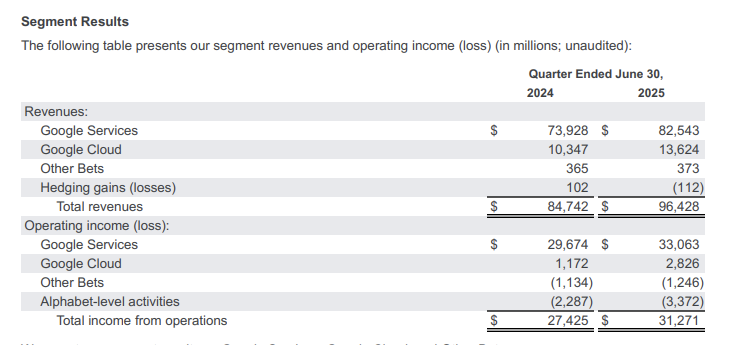

## Final Thoughts

The key idea behind this notebook isn’t just retrieval, it’s **structure preservation**.

By parsing documents with Unstructured and saving tables in HTML form, we retain the original layout, semantics, and visual grouping — all of which are lost in plain text formats. That structure becomes a powerful substrate for downstream systems.

With structured HTML in hand, your agents can:
- Render tables cleanly in a UI
- Summarize rows, columns, or headers in isolation
- Compare tables across documents
- Answer questions with specific numeric context
- Or just decide when *not* to respond, if structure is missing

This approach creates a flexible interface between messy PDFs and agentic logic, giving you both precision and creativity in how your applications interact with financial data.

Preserve structure early. Use it however you want later.